In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.tabular import *

In [3]:
torch.cuda.set_device(1)

## Rossmann

In [4]:
path = Path('data/rossmann')
path.ls()

[PosixPath('data/rossmann/googletrend.csv'),
 PosixPath('data/rossmann/sample_submission.csv'),
 PosixPath('data/rossmann/state_names.csv'),
 PosixPath('data/rossmann/store_states.csv'),
 PosixPath('data/rossmann/store.csv'),
 PosixPath('data/rossmann/test.csv'),
 PosixPath('data/rossmann/train.csv'),
 PosixPath('data/rossmann/weather.csv'),
 PosixPath('data/rossmann/.ipynb_checkpoints'),
 PosixPath('data/rossmann/joined'),
 PosixPath('data/rossmann/joined_test'),
 PosixPath('data/rossmann/df'),
 PosixPath('data/rossmann/train_clean'),
 PosixPath('data/rossmann/test_clean')]

In [5]:
train_df=pd.read_pickle(path/'train_clean')

In [6]:
train_df.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,5,2015-07-31,5263,555,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,7.0,0.0,5.0
1,1,2,5,2015-07-31,6064,625,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,2,3,5,2015-07-31,8314,821,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
3,3,4,5,2015-07-31,13995,1498,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,4,5,5,2015-07-31,4822,559,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0


In [7]:
n = len(train_df); n

844338

## Experimenting with a sample

In [8]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[:1000]]
small_cont_vars = ['CompetitionDistance','Mean_Humidity'] # Variaveis coninuas
small_cat_vars = ['Store','DayOfWeek', 'PromoInterval'] #Variaveis Categorias
small_train_df = small_train_df[small_cat_vars+small_cont_vars +['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [9]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
1218,106,4,NaN,1390.0,55,8253
1288,176,4,NaN,3770.0,73,5464
1454,343,4,"Jan,Apr,Jul,Oct",18650.0,73,8420
1570,459,4,"Feb,May,Aug,Nov",250.0,86,10847
2133,1023,4,"Jan,Apr,Jul,Oct",3740.0,51,6348


In [10]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
1218,106,4,NaN,1390.0,55,8253
1288,176,4,NaN,3770.0,73,5464
1454,343,4,"Jan,Apr,Jul,Oct",18650.0,73,8420
1570,459,4,"Feb,May,Aug,Nov",250.0,86,10847
2133,1023,4,"Jan,Apr,Jul,Oct",3740.0,51,6348


In [11]:
categorify = Categorify(small_cat_vars,small_cont_vars)
categorify(small_train_df)
categorify(small_test_df,test=True)

In [12]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
1218,106,4,NaN,1390.0,55,8253
1288,176,4,NaN,3770.0,73,5464
1454,343,4,"Jan,Apr,Jul,Oct",18650.0,73,8420
1570,459,4,"Feb,May,Aug,Nov",250.0,86,10847
2133,1023,4,"Jan,Apr,Jul,Oct",3740.0,51,6348


In [13]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [14]:
small_train_df['PromoInterval'].cat.codes[:5]

1218   -1
1288   -1
1454    1
1570    0
2133    1
dtype: int8

In [15]:
fill_missing = FillMissing(small_cat_vars,small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df,test=True)

In [16]:
small_train_df[small_train_df['CompetitionDistance_na']==True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
28837,879,4,"Feb,May,Aug,Nov",2400.0,68,4757,True
131320,879,3,"Feb,May,Aug,Nov",2400.0,70,2994,True


### Preparing full data set

In [17]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [18]:
len(train_df),len(test_df)

(844338, 41088)

In [19]:
procs = [FillMissing, Categorify, Normalize]

In [20]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
        'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
        'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
        'SchoolHoliday_fw', 'SchoolHoliday_bw']
cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h',
       'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
       'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [21]:
dep_var= "Sales" #dependent variable
df=train_df[cat_vars+cont_vars+[dep_var,'Date']].copy()

In [22]:
test_df['Date'].min(),test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [23]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [24]:
valid_idx=range(cut)

In [25]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [26]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                    .split_by_idx(valid_idx)
                    .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                    .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                    .databunch())

In [27]:
doc (FloatList)

class FloatList [source] [test] FloatList ( items : Iterator , log : bool = False , classes : Collection = None , ** kwargs ) :: ItemList 
 
 × No tests found for FloatList . To contribute a test please refer to this guide and this discussion . ItemList suitable for storing the floats in items for regression. Will add a log if this flag is True . 
 Show in docs

## Model

In [28]:
max_log_y = np.log (np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0,max_log_y],device = defaults.device)

In [30]:
learn = tabular_learner(data,layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04,y_range=y_range,metrics=exp_rmspe)

In [31]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


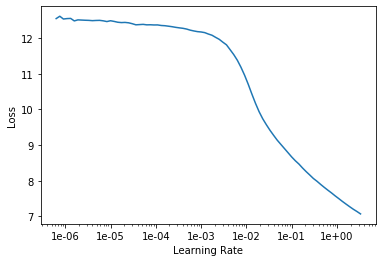

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(6,1e-2,wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.035727,0.029554,0.181359,02:30
1,0.041086,0.068046,0.313899,02:29
2,0.039925,0.027952,0.163811,02:29
3,0.031109,0.039722,0.220147,02:30
4,0.021425,0.020541,0.133872,02:29
5,0.014138,0.013230,0.114090,02:29


In [36]:
learn.save('1')

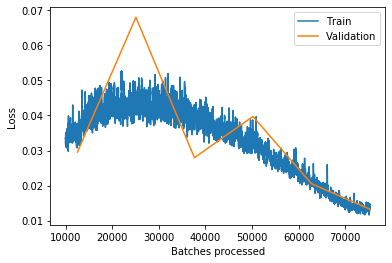

In [40]:
learn.recorder.plot_losses(skip_start=10000)

In [41]:
learn.load('1');

In [ ]:
learn.fit_one_cycle(5,3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.013045,0.015332,0.112424,02:28
1,0.012561,0.016319,0.114496,02:28
2,0.011851,0.013926,0.111549,02:30


In [ ]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)